In [2]:
import xarray as xr
import pandas as pd
import geopandas as gpd
import pygrib
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

In [3]:
ds = xr.open_dataset("ERA5_califonria_test.grib", engine = "cfgrib")   ###YOUR DATA HERE

In [4]:
ds #overview of grib file

<xarray.Dataset>
Dimensions:     (latitude: 97, longitude: 111, step: 24, time: 245)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2019-12-31 2020-01-01 ... 2020-08-31
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 1 days 00:00:00
    surface     int64 ...
  * latitude    (latitude) float64 42.09 41.99 41.89 41.79 ... 32.69 32.59 32.49
  * longitude   (longitude) float64 -125.2 -125.1 -125.0 ... -114.3 -114.2
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    d2m         (time, step, latitude, longitude) float32 ...
    t2m         (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2020-11-16T13:53:47 GRIB to CDM+CF via cfgrib-0....

In [6]:
grbs = pygrib.open("ERA5_califonria_test.grib") #open grib filde with pygrib

In [7]:
grbs.seek(0) #resets message seeks, whatever that means.
grb = grbs[2] #queries first message (idexes start at 1 for grib files)
grb #returns first message, basically first instance of the data

2:2 metre temperature:K (instant):regular_ll:surface:level 0:fcst time 24 hrs:from 201912310000

<function matplotlib.pyplot.show(close=None, block=None)>

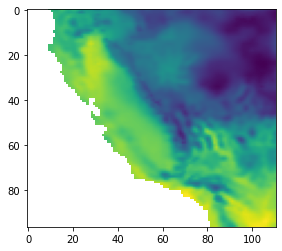

In [8]:
plt.imshow(grb.values) #grb.values returns values for particulat message, here we can preview
plt.show

In [6]:
lats, lons = grb.latlons() #store latitute and longitude as 2-D numpy arrays
grib_value = grb.values #store values as 2-array masked array (check out numpy masked arrays)

In [7]:
comb_array = np.vstack([grib_value.data.ravel(),lats.ravel(), lons.ravel()]).T  #flattens data frame and joins them to creat 3 colums with data
comb_array.shape

(10767, 3)

In [8]:
grib_df = pd.DataFrame(comb_array,columns =[grb.name,"LATITUDE","LONGITUDE"])
grib_df = grib_df.replace(9999, np.nan)
grib_df.head()

,2 metre temperature,LATITUDE,LONGITUDE
0,NaN,42.09,-125.17
1,NaN,42.09,-125.07
2,NaN,42.09,-124.97
3,NaN,42.09,-124.87
4,NaN,42.09,-124.77


In [9]:
grib_gdf = gpd.GeoDataFrame(grib_df, geometry=gpd.points_from_xy(grib_df.LONGITUDE, grib_df.LATITUDE), crs = {"init":"EPSG:4326"})
grib_gdf = grib_gdf.to_crs("EPSG:3857")
grib_gdf

/Users/pedrogalarza/miniconda3/envs/geopandas_env/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,2 metre temperature,LATITUDE,LONGITUDE,geometry
0,NaN,42.09,-125.17,POINT (-13933860.663 5174470.556)
1,NaN,42.09,-125.07,POINT (-13922728.714 5174470.556)
2,NaN,42.09,-124.97,POINT (-13911596.764 5174470.556)
3,NaN,42.09,-124.87,POINT (-13900464.815 5174470.556)
4,NaN,42.09,-124.77,POINT (-13889332.866 5174470.556)
...,...,...,...,...
10762,291.939941,32.49,-114.57,POINT (-12753874.060 3827804.007)
10763,291.336914,32.49,-114.47,POINT (-12742742.111 3827804.007)
10764,290.510742,32.49,-114.37,POINT (-12731610.162 3827804.007)
10765,289.697754,32.49,-114.27,POINT (-12720478.213 3827804.007)


In [10]:
##user-input:
home_dir = "/Users/pedrogalarza/Documents/NYU-MSDS/2020_fall/DSGA-1001/Project-Wildfire/"
data_dir = os.path.join(home_dir, 'wildfires-1001/data/')

In [11]:
#import california geometries

#State of Califonria
ca_boundary_path = os.path.join(data_dir, 'clean_data/CA_boundary', 'CA_boundary.shp')
CA_boundaries_gdf = gpd.read_file(ca_boundary_path)

#CA grid map
county_grid_path = os.path.join(data_dir, 'clean_data/county_grid/county_grid.shp')
county_grid_gdf = gpd.read_file(county_grid_path)

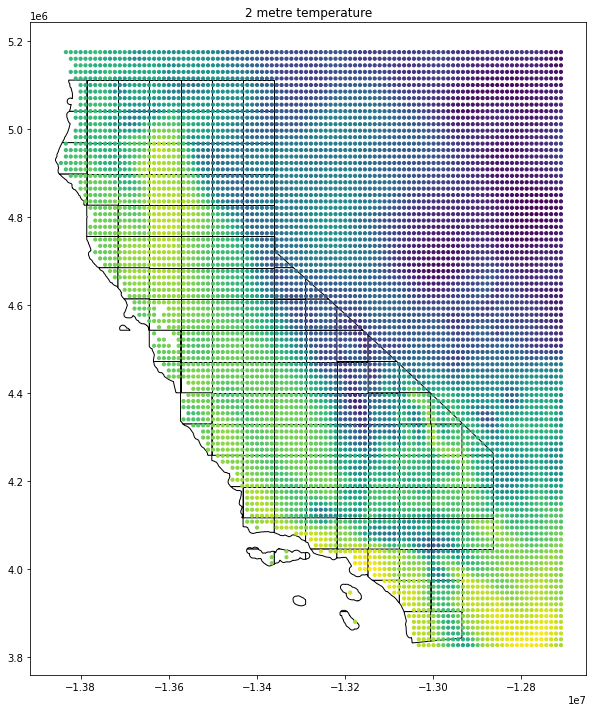

In [12]:
#plot messsege data over grid partition

ax1 =county_grid_gdf.plot(color='white', edgecolor='black',figsize=(12,12))
grib_gdf.plot(ax = ax1,column=str(grb.name),markersize=10,figsize=(15,15))
plt.title(grb.name)
plt.show()

In [13]:
from datetime import datetime

message_feautres = str(grb).split(":")
message_date = message_feautres[-1][5:-4]
message_date = message_date[:4]+"-"+message_date[4:6]+"-"+message_date[-2:]
message_hours = str(int(message_feautres[-2][10:-4])%24)
message_feature = message_feautres[1]

date_time_str = message_date+" "+message_hours
date_time_obj = datetime.strptime(date_time_str, '%Y-%m-%d %H')

In [14]:
#groupby grid section adn aggregate data by mean
grib_grid_join = gpd.sjoin(county_grid_gdf, grib_gdf, op = 'contains', how='left').groupby("GRID_ID").aggregate({grb.name:"mean"})
grib_grid_join.columns=["{} mean".format(grb.name)]

#join aggregated data to origional grid df, add date time
grib_county_join = county_grid_gdf.join(grib_grid_join, on = "GRID_ID")
grib_county_join['date-time'] = grb.validDate
grib_county_join

,NAME,COUNTYFP,GEOID,ALAND,AWATER,COUNTY_ARE,GRID_AREA,GRID_ID,COUNTY_GRI,COUNTY_G_1,geometry,2 metre temperature mean,date-time
0,Plumas,063,06063,6612400993,156387635,1.155000e+10,5.041000e+09,49.0,4.936293e+09,0.427385,"POLYGON ((-13502275.000 4897930.000, -13431275...",276.473298,2019-12-31
1,Sierra,091,06091,2468694587,23299110,4.200450e+09,5.041000e+09,50.0,1.535563e+09,0.365571,"POLYGON ((-13502275.000 4826930.000, -13431275...",281.664774,2019-12-31
2,Sierra,091,06091,2468694587,23299110,4.200450e+09,5.041000e+09,65.0,2.544187e+09,0.605694,"POLYGON ((-13431275.000 4826930.000, -13360275...",275.811947,2019-12-31
3,Sacramento,067,06067,2499183617,76073827,4.205267e+09,5.041000e+09,39.0,2.029400e+09,0.482585,"POLYGON ((-13573275.000 4684930.000, -13502275...",287.152393,2019-12-31
4,Contra Costa,013,06013,1871930816,209819213,3.351027e+09,5.041000e+09,40.0,1.618024e+09,0.482844,"POLYGON ((-13573275.000 4613930.000, -13502275...",287.148844,2019-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,Tulare,107,06107,12495016292,37081410,1.929486e+10,5.041000e+09,98.0,4.535463e+09,0.235061,"POLYGON ((-13289275.000 4400930.000, -13218275...",283.154618,2019-12-31
130,Tehama,103,06103,7639720404,32276063,1.313738e+10,5.041000e+09,25.0,4.171626e+09,0.317539,"POLYGON ((-13644275.000 4897930.000, -13573275...",289.463916,2019-12-31
131,Butte,007,06007,4238423343,105325812,7.340035e+09,5.041000e+09,36.0,2.479630e+09,0.337823,"POLYGON ((-13573275.000 4897930.000, -13502275...",285.204183,2019-12-31
132,Stanislaus,099,06099,3874642752,46376455,6.250517e+09,5.041000e+09,54.0,3.614684e+09,0.578302,"POLYGON ((-13502275.000 4542930.000, -13431275...",286.457450,2019-12-31


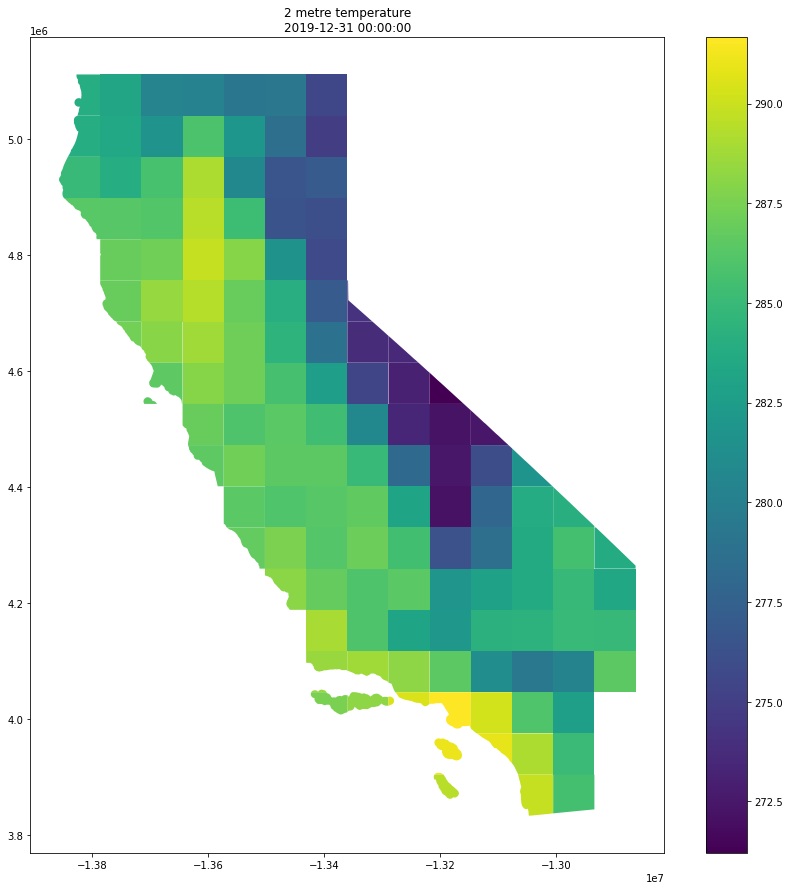

In [15]:
grib_county_join.plot(column='{} mean'.format(message_feature),figsize = (15,15), legend=True)
plt.title(message_feature + "\n" + str(date_time_obj))
plt.show()

In [16]:
#ok now lets start looping though these messages......
grbs.seek(0)
grb_list = []
for grb_element in grbs:
    grb_element.hour = int(str(grb_element).split(":")[-2][10:-4])%24  #rewrite hours
    if grb_element.hour == 12 and grb_element.parameterName == '2 metre temperature':
        grb_list.append(grb_element)

In [17]:
def create_latslongs_df(grib_obj):
    lats, lons = grib_obj.latlons() #store latitute and longitude as 2-D numpy arrays
    grib_values = grib_obj.values.data.ravel() #store values as 2-array masked array (check out numpy masked arrays)
    date = grib_obj.validDate
    #time = grib_obj.dataTime
    #date-time = 
    comb_array = np.vstack([grib_values,lats.ravel(), lons.ravel(),np.repeat(date,len(grib_values))]).T  #flattens data frame and joins them to creat 3 colums with data
    
    grib_df = pd.DataFrame(comb_array,columns =[grb.name,"LATITUDE","LONGITUDE","date"])
    grib_df = grib_df.replace(9999, np.nan)
    return(grib_df)

create_latslongs_df(grb_list[1])

,2 metre temperature,LATITUDE,LONGITUDE,date
0,NaN,42.09,-125.17,2020-01-02
1,NaN,42.09,-125.07,2020-01-02
2,NaN,42.09,-124.97,2020-01-02
3,NaN,42.09,-124.87,2020-01-02
4,NaN,42.09,-124.77,2020-01-02
...,...,...,...,...
10762,282.610596,32.49,-114.57,2020-01-02
10763,283.675049,32.49,-114.47,2020-01-02
10764,284.049561,32.49,-114.37,2020-01-02
10765,283.775146,32.49,-114.27,2020-01-02


In [18]:
element_geospatial_list = []
for element in grb_list:
    element_geospatial_list.append(create_latslongs_df(element))
combined_geospatial_df = pd.concat(element_geospatial_list)

In [22]:
combined_geospatial_df.reset_index(drop=True,inplace=True)
combined_geospatial_df

,2 metre temperature,LATITUDE,LONGITUDE,date
0,NaN,42.09,-125.17,2020-01-01
1,NaN,42.09,-125.07,2020-01-01
2,NaN,42.09,-124.97,2020-01-01
3,NaN,42.09,-124.87,2020-01-01
4,NaN,42.09,-124.77,2020-01-01
...,...,...,...,...
2627143,300.912842,32.49,-114.57,2020-08-31
2627144,300.769287,32.49,-114.47,2020-08-31
2627145,300.426514,32.49,-114.37,2020-08-31
2627146,300.097412,32.49,-114.27,2020-08-31


In [66]:
averaged_geospatial_df = combined_geospatial_df.groupby([combined_geospatial_df['date'].dt.strftime('%B%Y'),"LATITUDE","LONGITUDE"]).mean()
averaged_geospatial_df.reset_index(inplace=True)
averaged_geospatial_df

,date,LATITUDE,LONGITUDE,2 metre temperature
0,April2020,32.49,-125.17,NaN
1,April2020,32.49,-125.07,NaN
2,April2020,32.49,-124.97,NaN
3,April2020,32.49,-124.87,NaN
4,April2020,32.49,-124.77,NaN
...,...,...,...,...
86131,May2020,42.09,-114.57,279.691335
86132,May2020,42.09,-114.47,278.891042
86133,May2020,42.09,-114.37,277.969545
86134,May2020,42.09,-114.27,277.383072


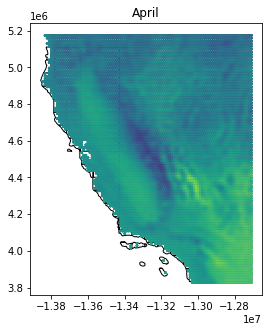

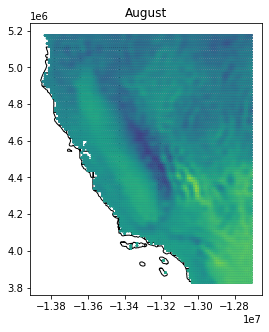

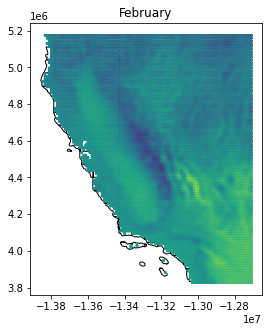

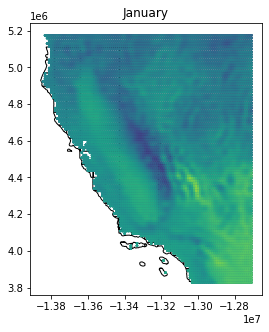

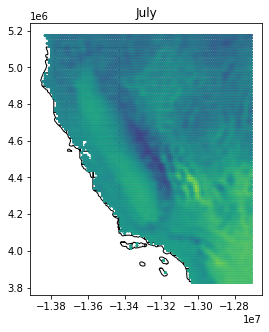

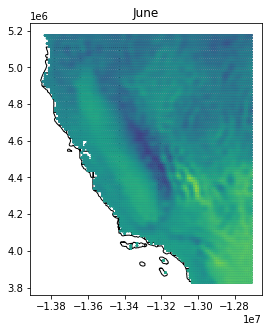

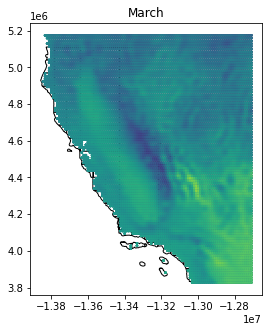

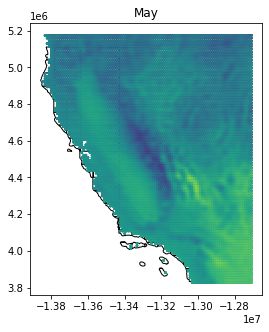

In [63]:
month_list = averaged_geospatial_gdf.date.unique()

for i in month_list:
    grouped = averaged_geospatial_gdf[averaged_geospatial_gdf["date"]==i]
    ax1 =county_grid_gdf.plot(color='white', edgecolor='black',figsize=(5,5), legend=True)
    averaged_geospatial_gdf.plot(ax = ax1,column=str(grb.name),markersize=2,figsize=(15,15))
    plt.title(i)
plt.show()